<a href="https://colab.research.google.com/github/erezimm/ML-ML/blob/master/GNN_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main notebook, to be run on Google Colab

## Import dependencies and download datasets

In [ ]:
!pip install dgl

import glob
from datetime import datetime
from os.path import basename

import astropy.io.ascii
import dgl
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

if not torch.cuda.is_available():
    raise Exception('Cuda unavailable, turn it on under Runtime>Change runtime type>GPU')
device = torch.device('cpu')

!wget -O data.zip https://github.com/erezimm/ML-ML/raw/master/data.zip
!unzip -o -q data.zip -d ./data
training_path = '/content/data/training_set'
validation_path = '/content/data/validation_set'

     |████████████████████████████████| 3.0MB 6.5MB/s 


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
--2020-08-05 17:13:57--  https://github.com/erezimm/ML-ML/raw/master/data.zip
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/erezimm/ML-ML/master/data.zip [following]
--2020-08-05 17:13:57--  https://raw.githubusercontent.com/erezimm/ML-ML/master/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59777 (58K) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  

## Create Datasets
Class CustomDataset loads all files and converts them to a list of graphs.
Each node in a graph is a data point, i.e. node features are days since start, mag, magerr

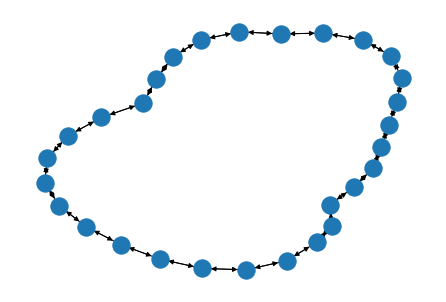

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, path):
        filelist = glob.glob(path+'/*')
        
        self.graphs = []
        self.isMicrolensed = []
        for fname in tqdm(filelist):
            filebasename = basename(fname)
            if filebasename.startswith('clean'):
                microlensed = torch.tensor([0])
            elif filebasename.startswith('microlensed'):
                microlensed = torch.tensor([1])
            else:
                raise Exception('Filename ' + fname + ' not clean_* or microlensed_*')
            
            with open(fname) as f:
                data = astropy.io.ascii.read(f.read())
                times, mags, magerrs = data['col1'], [], data['col3']
                for m, err in zip(data['col2'], magerrs):
                    mags.append(round(m, len(str(err).split('.')[1])))
                zipped = list(zip(times, mags, magerrs))
                zipped.sort(key=lambda tup: tup[0])
                times, mags, magerrs = zip(*zipped)

                n = len(times)
                g = dgl.DGLGraph()
                g.add_nodes(n)
                g.ndata['time'] = torch.tensor(times).float()  # days
                g.ndata['mag'] = torch.tensor(mags).float()
                g.ndata['magerr'] = torch.tensor(magerrs).float()
                g.add_edges([i for i in range(n)], [(i+1)%n for i in range(n)])
                g.add_edges([i for i in range(n)], [(i-1)%n for i in range(n)])
                
                self.graphs.append(g)
                self.isMicrolensed.append(microlensed)
        
    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], self.isMicrolensed[idx]


train_ds = CustomDataset(training_path)
# validation_ds = CustomDataset(validation_path)

nx.draw(dgl.to_networkx(train_ds[20][0]))

In [ ]:
def collate(samples):
    # The input `samples` is a list, a batch of whatever comes out of your dataset object
    graphs = [x[0] for x in samples]
    labels = [x[1] for x in samples]
    
    batched_graph = dgl.batch(graphs, node_attrs=['time', 'mag', 'magerr'])
    targets = torch.cat(labels)
    
    return batched_graph, targets.unsqueeze(1).float()

## The Newtwork

In [ ]:
n_ft = 3  # number of node features (time, mag, magerr)

class EdgeNetwork(nn.Module):
    def __init__(self, node_hidrep, edge_hidrep):
        super(EdgeNetwork, self).__init__()
        n_in = 2*node_hidrep
        
        # network:
        sizes = [n_in] + [] + [edge_hidrep]

        layers = []
        for i in range(len(sizes)-1):
            layers.extend([nn.Linear(sizes[i], sizes[i+1]), nn.ReLU()])
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        input = torch.cat((x.dst['node_hidrep'], x.src['node_hidrep']), dim=1)
        output = self.network(input)
        return {'edge_hidrep': output }

    
class NodeNetwork(nn.Module):
    def __init__(self, node_hidrep, edge_hidrep):
        super(NodeNetwork, self).__init__()
        n_in = edge_hidrep + node_hidrep

        # network:
        sizes = [n_in] + [] + [node_hidrep]

        layers = []
        for i in range(len(sizes)-1):
            layers.extend([nn.Linear(sizes[i], sizes[i+1]), nn.ReLU()])
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        mb = torch.mean( x.mailbox['edge_hidrep'] , dim=1 )
        input = torch.cat((mb, x.data['node_hidrep']), dim=1)
        out = self.network(input)
        return {'node_hidrep': out }


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        # networks:
        node_hidrep, edge_hidrep = 10, 10
        sizes_nodeinit = [n_ft] + [] + [node_hidrep]
        self.update_loop_length = 20

        layers = []
        for i in range(len(sizes_nodeinit)-1):
            layers.extend([nn.Linear(sizes_nodeinit[i], sizes_nodeinit[i+1]), nn.ReLU()])
        self.node_init = nn.Sequential(*layers)
        self.edge_network = EdgeNetwork(node_hidrep, edge_hidrep)
        self.node_network = NodeNetwork(node_hidrep, edge_hidrep)
        
    def forward(self, g):
        features = torch.tensor(list(zip(g.ndata['time'], g.ndata['mag'], g.ndata['magerr'])))
        g.ndata['node_hidrep'] = self.node_init(features)

        for i in range(self.update_loop_length):
            g.update_all(self.edge_network, self.node_network)
        
        # eventually take max of all entries in all nodes (?), maybe you can apply functions with dgl.function ?
        output = dgl.max_nodes(g, 'node_hidrep')
        output = torch.max(output, 1, keepdim=True)[0]
        return output

In [ ]:
net = Classifier()
net.to(device)

Classifier(
  (node_init): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=20, out_features=10, bias=True)
      (1): ReLU()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=20, out_features=10, bias=True)
      (1): ReLU()
    )
  )
)

## Train

In [ ]:
# options:
loss_func = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer = optim.Adam(net.parameters(), lr=0.001)
n_epochs = 50


data_loader = DataLoader(train_ds, batch_size=30, shuffle=True, collate_fn=collate)
for epoch in tqdm(range(n_epochs)):
    net.train()
    losses = []
    for x,y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = net(x)
        # print(output.shape, y.shape)
        loss = loss_func(output,y)
        losses.append(float(loss))
        loss.backward()
        optimizer.step()
    
    print(epoch, ':', np.mean(np.array(losses)))      

0 : 0.6946641951799393
1 : 0.703291267156601
2 : 0.6912826299667358
3 : 0.6912491470575333
4 : 0.7021836042404175
5 : 0.6964633762836456
6 : 0.7014075070619583
7 : 0.6959450542926788
8 : 0.6934103518724442
9 : 0.6910473108291626
10 : 0.6995846182107925
11 : 0.6992023587226868
12 : 0.6968308538198471
13 : 0.6929281502962112
14 : 0.6967527717351913
15 : 0.6947953850030899
16 : 0.6980041712522507
17 : 0.6978959739208221
18 : 0.6976487785577774
19 : 0.6943570077419281
20 : 0.6958933472633362
21 : 0.6897095143795013
22 : 0.6896114647388458
23 : 0.6942376047372818
24 : 0.692691445350647
25 : 0.6958823353052139
26 : 0.6942518949508667
27 : 0.6942193806171417
28 : 0.6926620006561279
29 : 0.6926684826612473
30 : 0.6942474991083145
31 : 0.695812851190567
32 : 0.6941892206668854
33 : 0.6913012266159058
34 : 0.6954094618558884
35 : 0.6926513314247131
36 : 0.6939233988523483
37 : 0.6952711939811707
38 : 0.6926829963922501
39 : 0.6938985884189606
40 : 0.6913761347532272
41 : 0.6938679218292236
42 : 

## Evaluate

Once you train your network you can evaluate on the test dataset, and compute the rate of false positive, false negative, etc,

train until you reach at least 60% true positive rate while maintaining a 90%+ true negative rate, and submit

In [ ]:
test_data_loader = DataLoader(test_ds, batch_size=30, shuffle=True, collate_fn=collate)

net.cpu()
net.eval()

true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0
total_positives = 0
total_negatives = 0

for i, (x,y) in enumerate(test_data_loader):
        
        y = y.data.numpy()

        prediction = net(x).cpu().data.numpy()
        
        prediction[prediction >= 0.5] = 1
        prediction[prediction <0.5] = 0
        
        total_positives+=len(np.where( y==1 )[0])
        total_negatives+=len(np.where( y==0 )[0])
        
        true_positive+= len(np.where( (prediction==y) & (y==1) )[0])
        true_negative+= len(np.where( (prediction==y) & (y==0) )[0])
        false_positive+= len(np.where( (prediction!=y) & (y==0) )[0])
        false_negative+= len(np.where( (prediction!=y) & (y==1) )[0])
        
        
print('true positive: ', true_positive/total_positives)
print(false_negative/total_positives)
print('true negative: ', true_negative/total_negatives)
print(false_positive/total_negatives)

NameError: ignored

## Save
Don't forget to download

In [ ]:
timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
torch.save(net.state_dict(), 'model_' + timestamp + '.pt')